<a href="https://colab.research.google.com/github/BME6938-SPR2023/final_project/blob/main/ImageSeg(Model1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Import libraries

In [14]:
import os.path as osp
from glob import glob
import shutil
from tqdm import tqdm
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import cv2

## Load data

In [3]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection"

Text(0.5, 1.0, 'MASK')

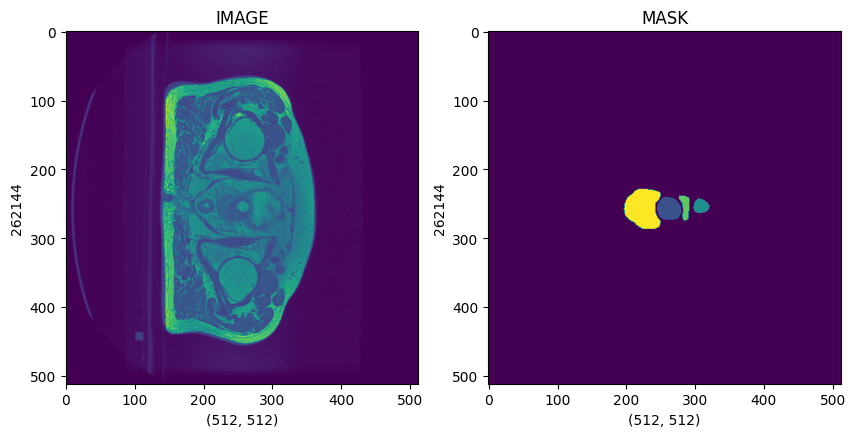

In [5]:
#sample image
img_nifti = nib.load("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/P1_03_Z38.nii")
img = img_nifti.get_fdata()
label_nifti = nib.load("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/labels/test/1_03_Z38.nii")
label = label_nifti.get_fdata()
#View image
# plt.imshow(img[:,:].T, cmap='Greys_r')
#example of image
figure,axis = plt.subplots(1,2,figsize=(10,10))
Plot_Color_Op = axis[0].imshow(img_nifti.get_fdata())
axis[0].set_xlabel(img_nifti.get_fdata().shape)
axis[0].set_ylabel(img_nifti.get_fdata().size)
axis[0].set_title("IMAGE")

axis[1].imshow(label)
axis[1].set_xlabel(label.shape)
axis[1].set_ylabel(label.size)
axis[1].set_title("MASK")

In [8]:
Stacked_train_path = Path("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/train")
Stacked_test_path = Path("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test")
labels_train_path = Path("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/labels/train")
labels_test_path = Path("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/labels/test")
T2_train_path =  Path("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/T2/train")
T2_test_path =  Path("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/T2/test")
dCT_train_path =  Path("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/dCT/train")
dCT_test_path =  Path("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/dCT/test")

In [10]:
Stacked_train_Images = list(Stacked_train_path.glob(r"*.nii"))
Stacked_test_Images = list(Stacked_test_path.glob(r"*.nii"))
labels_train_Images = list(labels_train_path .glob(r"*.nii"))
labels_test_Images = list(labels_test_path .glob(r"*.nii"))
T2_train_Images = list(T2_train_path.glob(r"*.nii"))
T2_test_Images = list(T2_test_path.glob(r"*.nii"))
dCT_train_Images = list(dCT_train_path .glob(r"*.nii"))
dCT_test_Images = list(dCT_test_path .glob(r"*.nii"))

In [11]:
print(len(Stacked_train_Images ))
print(len(labels_train_Images))

15
15


## Data preprocessing

In [13]:
#create a pd series of and concat to create the train data
Stacked_train_Series = pd.Series(Stacked_train_Images,name="IMAGE").astype(str)
labels_train_Series = pd.Series(labels_train_Images,name="LABEL").astype(str)

train_data =  pd.concat([Stacked_train_Series,labels_train_Series],axis=1)

In [17]:
#Get image data
label_vals = []
Stacked_train_List = []
labels_train_List = []

for i_img,i_mask in zip(train_data["IMAGE"].values,train_data["LABEL"].values):
    Reading_Train_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)
    
    X_Images = Reading_Train_NII.get_fdata()
    X_Labels = Reading_Label_NII.get_fdata()
     
    Selecting_Image = X_Images / 255.
    Selecting_Label = X_Labels / 255.
    
    #check shape
    # print(np.shape(Selecting_Image))
    # print(np.shape(Selecting_Label))
    # print("---"*15)

    if np.mean(Selecting_Label) > 0:
        label_vals.append(1)
        Selecting_Image = Selecting_Image.astype("float32")
        Selecting_Label = Selecting_Label.astype("float32")

        resized_IMG = cv2.resize(Selecting_Image,(256,256))
        resized_LABEL = cv2.resize(Selecting_Label,(256,256))

        print(np.shape(resized_IMG))
        print(np.shape(resized_LABEL))
        print("---"*15)

        Stacked_train_List.append(resized_IMG)
        labels_train_List.append(resized_LABEL)

    else:
        label_vals.append(0)

(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
---------------------------------------------
(256, 256)
(256, 256)
--------------------------

In [18]:
print(np.shape(np.array(Stacked_train_List)))
print(np.shape(np.array(labels_train_List)))

(15, 256, 256)
(15, 256, 256)


In [20]:
#convert to array
Stacked_train_arr = np.array(Stacked_train_List,dtype="float32")
labels_train_arr = np.array(labels_train_List,dtype="float32")

In [22]:
#reshape
Stacked_img = Stacked_train_arr.reshape(Stacked_train_arr.shape[0],Stacked_train_arr.shape[1],Stacked_train_arr.shape[2],1)
Stacked_label = labels_train_arr.reshape(labels_train_arr.shape[0],labels_train_arr.shape[1],labels_train_arr.shape[2],1)

print(Stacked_img .shape)
print(Stacked_label.shape)

(15, 256, 256, 1)
(15, 256, 256, 1)


In [23]:
BATCH_SIZE = 8
dataset = tf.data.Dataset.from_tensor_slices((Stacked_img , Stacked_label))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None))>

## Build Model


In [24]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape, Conv2DTranspose,\
LeakyReLU, GaussianNoise, GlobalMaxPooling2D, ReLU, Input, Concatenate
from keras import models
from keras import layers
import tensorflow as tf
from keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from keras.utils import plot_model
from keras.models import Model
#OPTIMIZER
from keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD

In [25]:
Encoder = Sequential()
#
Encoder.add(Conv2D(32,(5,5),kernel_initializer = 'he_normal',use_bias=True,name="ENCODER_INPUT"))
Encoder.add(BatchNormalization())
Encoder.add(ReLU())
#
Encoder.add(Conv2D(64,(5,5),kernel_initializer = 'he_normal',use_bias=True))
Encoder.add(BatchNormalization())
Encoder.add(ReLU())
#
Encoder.add(Conv2D(128,(2,2),kernel_initializer = 'he_normal',use_bias=True))
Encoder.add(BatchNormalization())
Encoder.add(ReLU())
#
Encoder.add(Conv2D(128,(2,2),kernel_initializer = 'he_normal',use_bias=True))
Encoder.add(BatchNormalization())
Encoder.add(ReLU())



Decoder = Sequential()
#
Decoder.add(Conv2DTranspose(128,(2,2)))
Decoder.add(ReLU())
#
Decoder.add(Conv2DTranspose(64,(2,2)))
Decoder.add(ReLU())
#
Decoder.add(Conv2DTranspose(32,(5,5)))
Decoder.add(ReLU())
#
Decoder.add(Conv2DTranspose(1,(5,5),name="DECODER_OUTPUT"))


In [27]:
model = Sequential([Encoder,Decoder])

In [31]:
model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.0000001),metrics=["accuracy"])

In [32]:
test_Model = model.fit(Stacked_img,Stacked_label,epochs=1)

1/1 [==============================] - 62s 62s/step - loss: 0.0099 - accuracy: 0.9817


## Prepare testing data

In [33]:
#create a pd series of and concat to create the train data
Stacked_test_Series = pd.Series(Stacked_test_Images,name="IMAGE").astype(str)
labels_test_Series = pd.Series(labels_test_Images,name="LABEL").astype(str)

test_data =  pd.concat([Stacked_test_Series,labels_test_Series],axis=1)

In [35]:
label_vals = []
Stacked_test_List = []
labels_test_List = []

for i_img,i_mask in zip(test_data["IMAGE"].values,test_data["LABEL"].values):
    Reading_Train_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)
    
    X_Images = Reading_Train_NII.get_fdata()
    X_Labels = Reading_Label_NII.get_fdata()
     
    Selecting_Image = X_Images / 255.
    Selecting_Label = X_Labels / 255.
    
    #check shape
    # print(np.shape(Selecting_Image))
    # print(np.shape(Selecting_Label))
    # print("---"*15)

    if np.mean(Selecting_Label) > 0:
        label_vals.append(1)
        Selecting_Image = Selecting_Image.astype("float32")
        Selecting_Label = Selecting_Label.astype("float32")

        resized_IMG = cv2.resize(Selecting_Image,(256,256))
        resized_LABEL = cv2.resize(Selecting_Label,(256,256))

        # print(np.shape(resized_IMG))
        # print(np.shape(resized_LABEL))
        # print("---"*15)

        Stacked_test_List.append(resized_IMG)
        labels_test_List.append(resized_LABEL)

    else:
        label_vals.append(0)

In [36]:
#convert to array
Stacked_test_arr = np.array(Stacked_test_List,dtype="float32")
labels_test_arr = np.array(labels_test_List,dtype="float32")

In [38]:
#reshape
StackedTS_img = Stacked_test_arr.reshape(Stacked_test_arr.shape[0],Stacked_test_arr.shape[1],Stacked_test_arr.shape[2],1)
StackedTS_label = labels_test_arr.reshape(labels_test_arr.shape[0],labels_test_arr.shape[1],labels_test_arr.shape[2],1)

In [39]:
BATCH_SIZE = 8
test_dataset = tf.data.Dataset.from_tensor_slices((StackedTS_img , StackedTS_label))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None))>

In [44]:
test_Model

In [46]:
model.evaluate(StackedTS_img, StackedTS_label)

1/1 [==============================] - 4s 4s/step - loss: 0.0107 - accuracy: 0.9779


[0.010660410858690739, 0.9779319763183594]

In [45]:
Stacked_prediction = model.predict(StackedTS_img)

1/1 [==============================] - 4s 4s/step


Text(0.5, 1.0, 'PREDICTION')

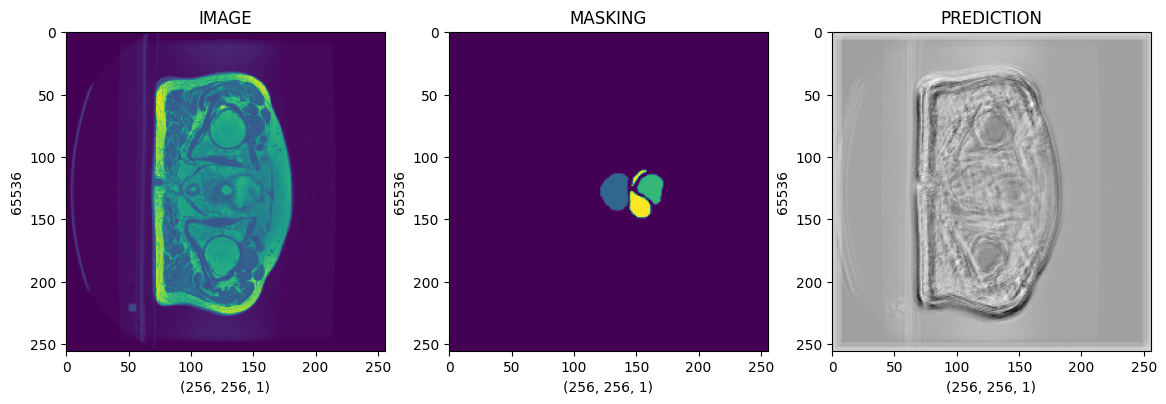

In [48]:
figure,axis = plt.subplots(1,3,figsize=(14,14))
img_number = 1

Original_Img = StackedTS_img[img_number]
Predict_Mask = Stacked_prediction[img_number]
Main_Mask = StackedTS_label[img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("IMAGE")
axis[1].imshow(Main_Mask)
axis[1].set_xlabel(Main_Mask.shape)
axis[1].set_ylabel(Main_Mask.size)
axis[1].set_title("MASKING")
axis[2].imshow(Predict_Mask,cmap="Greys_r")
axis[2].set_xlabel(Predict_Mask.shape)
axis[2].set_ylabel(Predict_Mask.size)
axis[2].set_title("PREDICTION")

##prepare T2 and dCT 

In [50]:
#create a pd series of and concat to create the train data
T2_test_Series = pd.Series(T2_test_Images,name="IMAGE").astype(str)
T2_labels_test_Series = pd.Series(labels_test_Images,name="LABEL").astype(str)

T2_test_data =  pd.concat([T2_test_Series,T2_labels_test_Series],axis=1)

dCT_test_Series = pd.Series(dCT_test_Images,name="IMAGE").astype(str)
dCT_labels_test_Series = pd.Series(labels_test_Images,name="LABEL").astype(str)

dCT_test_data =  pd.concat([dCT_test_Series,dCT_labels_test_Series],axis=1)

In [52]:
label_vals = []
T2_test_List = []
T2_labels_test_List = []

for i_img,i_mask in zip(T2_test_data["IMAGE"].values,T2_test_data["LABEL"].values):
    Reading_Train_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)
    
    X_Images = Reading_Train_NII.get_fdata()
    X_Labels = Reading_Label_NII.get_fdata()
     
    Selecting_Image = X_Images / 255.
    Selecting_Label = X_Labels / 255.
    
    #check shape
    # print(np.shape(Selecting_Image))
    # print(np.shape(Selecting_Label))
    # print("---"*15)

    if np.mean(Selecting_Label) > 0:
        label_vals.append(1)
        Selecting_Image = Selecting_Image.astype("float32")
        Selecting_Label = Selecting_Label.astype("float32")

        resized_IMG = cv2.resize(Selecting_Image,(256,256))
        resized_LABEL = cv2.resize(Selecting_Label,(256,256))

        # print(np.shape(resized_IMG))
        # print(np.shape(resized_LABEL))
        # print("---"*15)

        T2_test_List.append(resized_IMG)
        T2_labels_test_List.append(resized_LABEL)

    else:
        label_vals.append(0)

In [53]:
label_vals = []
dCT_test_List = []
dCT_labels_test_List = []

for i_img,i_mask in zip(dCT_test_data["IMAGE"].values,dCT_test_data["LABEL"].values):
    Reading_Train_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)
    
    X_Images = Reading_Train_NII.get_fdata()
    X_Labels = Reading_Label_NII.get_fdata()
     
    Selecting_Image = X_Images / 255.
    Selecting_Label = X_Labels / 255.
    
    #check shape
    # print(np.shape(Selecting_Image))
    # print(np.shape(Selecting_Label))
    # print("---"*15)

    if np.mean(Selecting_Label) > 0:
        label_vals.append(1)
        Selecting_Image = Selecting_Image.astype("float32")
        Selecting_Label = Selecting_Label.astype("float32")

        resized_IMG = cv2.resize(Selecting_Image,(256,256))
        resized_LABEL = cv2.resize(Selecting_Label,(256,256))

        # print(np.shape(resized_IMG))
        # print(np.shape(resized_LABEL))
        # print("---"*15)

        dCT_test_List.append(resized_IMG)
        dCT_labels_test_List.append(resized_LABEL)

    else:
        label_vals.append(0)

In [55]:
#T2 - convert to array
T2_test_arr = np.array(T2_test_List,dtype="float32")
T2_labels_test_arr = np.array(T2_labels_test_List,dtype="float32")

#reshape
T2TS_img = T2_test_arr.reshape(T2_test_arr.shape[0],T2_test_arr.shape[1],T2_test_arr.shape[2],1)
T2TS_label = T2_labels_test_arr.reshape(T2_labels_test_arr.shape[0],T2_labels_test_arr.shape[1],T2_labels_test_arr.shape[2],1)

In [56]:
#dCT convert to array
dCT_test_arr = np.array(dCT_test_List,dtype="float32")
dCT_labels_test_arr = np.array(dCT_labels_test_List,dtype="float32")

#reshape
dCTTS_img = dCT_test_arr.reshape(dCT_test_arr.shape[0],dCT_test_arr.shape[1],dCT_test_arr.shape[2],1)
dCTTS_label = dCT_labels_test_arr.reshape(dCT_labels_test_arr.shape[0],dCT_labels_test_arr.shape[1],dCT_labels_test_arr.shape[2],1)

In [57]:
model.evaluate(T2TS_img , T2TS_label)

1/1 [==============================] - 6s 6s/step - loss: 0.0417 - accuracy: 0.9748


[0.04167228192090988, 0.9748039245605469]

In [58]:
model.evaluate(dCTTS_img , dCTTS_label)

1/1 [==============================] - 5s 5s/step - loss: 0.0087 - accuracy: 0.9787


[0.00866643339395523, 0.9787025451660156]